# Illegal Logging Detection
<h4>Blake Rayvid - <a href=https://github.com/brayvid>https://github.com/brayvid</a></h4>

# Feature extraction

In [1]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.7 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import resampy
import librosa
import logging

logging.basicConfig(level=logging.DEBUG)

def extract_features(file_path, max_len=200):
    try:
        logging.debug(f"Attempting to load {file_path}")

        # Load audio file
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        logging.debug(f"Loaded {file_path}: audio shape {audio.shape}, sample rate {sample_rate}")

        # Generate Mel-spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
        logging.debug(f"Generated Mel-spectrogram for {file_path}: shape {mel_spectrogram.shape}")

        # Convert power spectrogram to dB
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        logging.debug(f"Converted Mel-spectrogram to dB for {file_path}: shape {log_mel_spectrogram.shape}")

        # Pad or truncate Mel-spectrogram
        if log_mel_spectrogram.shape[1] < max_len:
            pad_width = max_len - log_mel_spectrogram.shape[1]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:, :max_len]

        return log_mel_spectrogram

    except FileNotFoundError:
        logging.error(f"File not found: {file_path}")
        return None
    except ValueError as ve:
        logging.error(f"Value error while processing file {file_path}: {ve}")
        return None
    except Exception as e:
        logging.error(f"Error processing file {file_path}: {e}")
        return None

def load_data(data_dir, max_len=200):
    features = []
    labels = []
    class_names = ['chainsaw', 'non_chainsaw']

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_path.endswith('.wav'):
                data = extract_features(file_path, max_len=max_len)
                if data is not None:
                    features.append(data)
                    labels.append(class_name)

    return np.array(features), np.array(labels)

# Load data
data_dir = '/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/data'
max_len = 200
X, y = load_data(data_dir, max_len=max_len)

if len(X) == 0:
    logging.error("No valid features extracted.")
else:
    logging.info(f"Extracted features from {len(X)} files.")

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [3]:
import pickle

# Save X and y to files using pickle
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/X_chainsaw.pkl', 'wb') as f:
    pickle.dump(X, f)
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/y_chainsaw.pkl', 'wb') as f:
    pickle.dump(y, f)

In [14]:
import pickle

# Load X and y from pickle file
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/X_chainsaw.pkl', 'rb') as f:
    X = pickle.load(f)
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/y_chainsaw.pkl', 'rb') as f:
    y = pickle.load(f)

In [4]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Build model

In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Input shape: (number of samples, frequency bins, time frames, 1)
input_shape = (128, X_train.shape[2], 1)
X_train = X_train.reshape(X_train.shape[0], 128, X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], 128, X_test.shape[2], 1)

model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 198, 32)      320       
                                                                 
 batch_normalization_3 (Bat  (None, 126, 198, 32)      128       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 126, 198, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 97, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 61, 97, 64)       

# Evaluate model

7/7 [==============================] - 0s 15ms/step - loss: 0.4494 - accuracy: 0.9950
Test accuracy: 0.9950248599052429
7/7 [==============================] - 0s 13ms/step
Precision: 0.9949494949494949
Recall: 1.0
F1 Score: 0.9974683544303797
AUC-ROC: 0.875


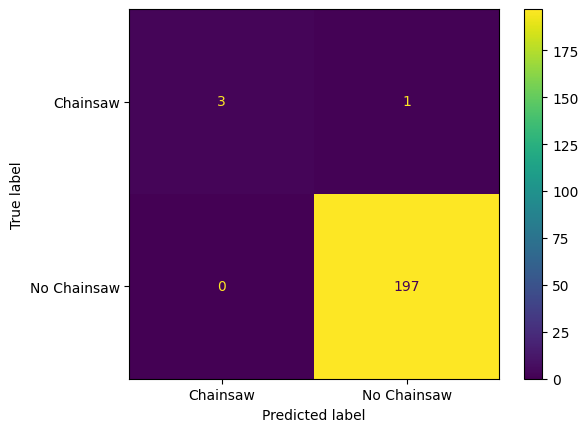

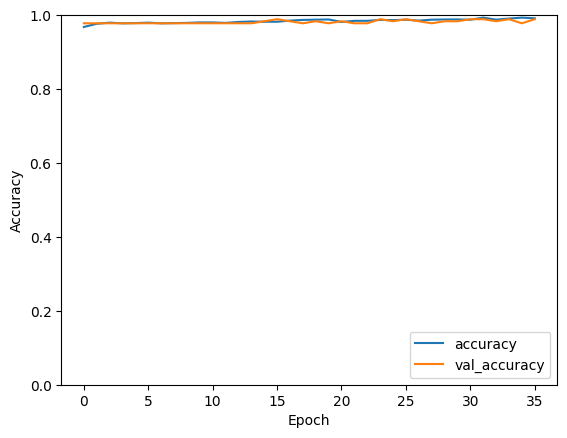

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_auc_score

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Calculate metrics
y_pred = np.argmax(model.predict(X_test), axis=1)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred)

# Display metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Chainsaw', 'No Chainsaw'])
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()